### This notebook retrieves data from projects.csv file and calculates values of project proportionality across different impact areas and presents the corresponding graph. This file also plots the performance of City Idea Project and Green Million projects against the expected Equal Shares performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 30)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.4f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())
print(pbsummary_with_vote_type['vote_type'].value_counts())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative
vote_type
approval      613
cumulative    104
ordinal        95
Name: count, dtype: int64


In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

pbprojects_df.head()

(19077, 21)
(19110, 22)


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,NaN,Compostons ensemble !,NaN,NaN,1000000.0000,0.7000,True,True,True,NaN,NaN,cumulative
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,NaN,Panneau d'affichage électronique extérieur,NaN,NaN,1000000.0000,3.5000,False,False,False,NaN,NaN,cumulative
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,NaN,Eclairage public d’un chemin piéton-vélo rue Ella Maillart,NaN,NaN,1000000.0000,5.0000,True,False,True,NaN,NaN,cumulative
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,NaN,"Tous à la Ramée à vélo ! A pied, en trottinette et rollers !",NaN,NaN,1000000.0000,39.0000,False,True,False,NaN,NaN,cumulative
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,NaN,Le parc des Anges vu par ses usagers,NaN,NaN,1000000.0000,16.8000,True,True,True,NaN,NaN,cumulative


In [6]:
# Shows that there are 70 winning projects whose budget percent is 100%, uses the total budget
full_budget_winners_projects = pbprojects_df[(pbprojects_df['budget_percent'] == 100) & ((pbprojects_df['is_greedy_winner'] == True) | (pbprojects_df['is_mes_winner'] == True))]
print(full_budget_winners_projects.shape)
print(full_budget_winners_projects['election_id'].unique())
test_df = full_budget_winners_projects[(full_budget_winners_projects['is_mes_winner'] == True) & (full_budget_winners_projects['is_greedy_winner'] == False)]
test_df.shape


(98, 22)
[ 20  21  25  26  30  31  32  35  36  38  40  42  43  44  45  46  47  48
  51  52  55  56  58  60  66  70  72  80  82  94 100 251 258 260 313 330
 423 460 465 557 682 684 688 690 692 694 696 698 700 704 706 708 717 719
 721 723 725 727 729 731 733 735 737 741 743 745 747 749 753 755 757 759
 761 763 765 767 774 776 777 778 779 783 785 786 788 790 791 793 794 795
 798 799 801 805 807 809 810 811]


(0, 22)

In [7]:
# Check for projects where cost of a given project is zero

print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]
print(invalid_projects)

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score category  \
893                  1511     18    NaN      NaN   

                                                        name  englishName  \
893  PROJECT WAS REMOVED BY THE CITY FOR VIOLATING THE RULES          NaN   

    target  total_budget  budget_percent  is_mes_winner  is_greedy_winner  \
893    NaN   295110.0000          0.0000           True              True   

     is_phragmen_winner  latitude  longitude vote_type  
893                True       NaN        NaN  approval  
    project_id  election_id
893          5           72
(19110, 22)
(19109, 22)


In [8]:
print("Subunit empty projects count: ", valid_pbprojects_df['subunit'].isna().sum())

empty_subunit_projects_df = valid_pbprojects_df[valid_pbprojects_df['subunit'].isna()][['election_id','project_id']]
print(empty_subunit_projects_df.shape)
print(empty_subunit_projects_df['election_id'].nunique())

# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)

# Cross checking for projects where by we have filled with subunit equalling the value 'all'
print(valid_pbprojects_df[valid_pbprojects_df['subunit'] == 'all'].shape)
print("Valid PB projects are: ", valid_pbprojects_df.shape)

Subunit empty projects count:  1928
(1928, 2)
25
(1928, 22)
Valid PB projects are:  (19109, 22)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_21988\660040707.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)


In [9]:
# setting up vote_percent column
print(valid_pbprojects_df.shape)
valid_pb_projects_total_selections = valid_pbprojects_df.groupby(['election_id'])['votes'].sum().reset_index()
print(valid_pb_projects_total_selections.shape)
valid_pb_projects_total_selections.rename(columns={'votes': 'total_votes_selection'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_total_selections, on='election_id', how='inner')
valid_pbprojects_df['vote_percent'] = round((valid_pbprojects_df['votes'] / valid_pbprojects_df['total_votes_selection'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 22)
(812, 2)
(19109, 24)


In [10]:
# Election ids of city idea and green million
aarau_election_id = valid_pbprojects_df[valid_pbprojects_df['country'] == 'Switzerland'].groupby(['election_id']).first().reset_index()['election_id']
aarau_election_id = aarau_election_id.values[0]

green_budget_election_id = valid_pbprojects_df[valid_pbprojects_df['unit'] == 'Wieliczka'].groupby(['election_id']).first().reset_index()['election_id']
green_budget_election_id = green_budget_election_id.values[0]

In [11]:
print("Distinct election IDs are: ", valid_pbprojects_df['election_id'].nunique())
valid_pbprojects_df_grouped_election = valid_pbprojects_df.groupby(['election_id','is_mes_winner'])['cost'].agg(['sum']).reset_index()
print(valid_pbprojects_df_grouped_election.head())
print(valid_pbprojects_df_grouped_election.shape)
print("Unique election IDs after grouping total costs: ", valid_pbprojects_df_grouped_election['election_id'].nunique())
mes_winners_grouped_project_count = valid_pbprojects_df_grouped_election[valid_pbprojects_df_grouped_election['is_mes_winner'] == True]
print(mes_winners_grouped_project_count.shape)

Distinct election IDs are:  812
   election_id  is_mes_winner       sum
0            1          False   1455000
1            1           True    997000
2            2          False  23588713
3            2           True   2350560
4            3          False    804294
(1563, 3)
Unique election IDs after grouping total costs:  812
(812, 3)


In [12]:
# setting additional column for used budget with MES aggregation
print(valid_pbprojects_df.shape)

elections_with_mes_winners = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True]
elections_with_greedy_winners = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True]
print("Elections with MES winners: ", elections_with_mes_winners['election_id'].nunique())
print("Elections with Greedy Winners: ", elections_with_greedy_winners['election_id'].nunique())

# Getting the total budget usage for MES winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_mes_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_mes_budget_usage.rename(columns={'cost': 'mes_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_mes_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['mes_budget_usage_percent'] = round((valid_pbprojects_df['mes_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 24)
Elections with MES winners:  812
Elections with Greedy Winners:  812
(19109, 26)


In [13]:
valid_pbprojects_df.dtypes

election_id                   int64
country                      object
unit                         object
subunit                      object
instance                      int64
project_id                   object
cost                          int64
project_voters_count          int64
votes                         int64
score                       float64
category                     object
name                         object
englishName                 float64
target                       object
total_budget                float64
budget_percent              float64
is_mes_winner                  bool
is_greedy_winner               bool
is_phragmen_winner             bool
latitude                    float64
longitude                   float64
vote_type                    object
total_votes_selection         int64
vote_percent                float64
mes_total_budget_usage        int64
mes_budget_usage_percent    float64
dtype: object

In [14]:
# Getting the total budget usage for utilitarian greedy winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_greedy_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner']].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_greedy_budget_usage.rename(columns={'cost': 'greedy_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_greedy_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['greedy_budget_usage_percent'] = round((valid_pbprojects_df['greedy_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 28)


In [15]:
## Fill empty values for category with the label 'uncategorized' to aid in further data analysis

valid_pbprojects_df['category'].value_counts()

# Checking to see if there are empty values for category in the entire project dataset
na_category_count = valid_pbprojects_df['category'].isna().sum()
print("Empty category values for PB projects are: ", na_category_count)

# Fill such empty values of category with the label uncategorized, so that it can aid in further data preprocessing
valid_pbprojects_df['category'].fillna('uncategorized', inplace=True)


print("Emtpy category values after filling na: ", valid_pbprojects_df['category'].isna().sum())
print("`uncategorized` category count for valid pb projects: ", valid_pbprojects_df[valid_pbprojects_df['category'] == 'uncategorized'].shape[0])

Empty category values for PB projects are:  8182
Emtpy category values after filling na:  0
`uncategorized` category count for valid pb projects:  8182


## Create additional columns for each category label

In [16]:
# Split the Categories column and create a set of unique categories
categories_set = set(category.strip() for categories in valid_pbprojects_df['category'] for category in categories.split(','))

# Create new columns with default value 0
for category in categories_set:
    valid_pbprojects_df[f'category_{category}'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    categories = row['category'].split(',')
    for category in categories:
        valid_pbprojects_df.at[index, f'category_{category.strip()}'] = 1
    
    if(len(categories) == 1 and (categories[0] == 'uncategorized')):
        valid_pbprojects_df.at[index, 'category_labels_count'] = 0
    else:
        valid_pbprojects_df.at[index, 'category_labels_count'] = int(len(categories))

valid_pbprojects_df.tail()

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type,total_votes_selection,vote_percent,mes_total_budget_usage,mes_budget_usage_percent,greedy_total_budget_usage,greedy_budget_usage_percent,category_education,category_public space,category_public transit and roads,category_environmental protection,category_welfare,category_uncategorized,category_health,category_sport,category_urban greenery,category_culture,category_labels_count
19104,1000,Switzerland,Aarau,Aarau,2023,18,5000,1703,88,146.0000,"health,education,welfare",Processing birth,NaN,"adults,families with children",50000.0000,10.0000,False,False,False,NaN,NaN,cumulative,8262,1.0650,49400,98.8000,49600,99.2000,1,0,0,0,1,0,1,0,0,0,3.0000
19105,1000,Switzerland,Aarau,Aarau,2023,17,3500,1703,67,102.0000,welfare,Senior Meeting,NaN,elderly,50000.0000,7.0000,False,False,False,NaN,NaN,cumulative,8262,0.8110,49400,98.8000,49600,99.2000,0,0,0,0,1,0,0,0,0,0,1.0000
19106,1000,Switzerland,Aarau,Aarau,2023,27,4000,1703,69,97.0000,"public space,public transit and roads",New edition of Telli-Map,NaN,"children,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,8262,0.8350,49400,98.8000,49600,99.2000,0,1,1,0,0,0,0,0,0,0,2.0000
19107,1000,Switzerland,Aarau,Aarau,2023,19,500,1703,56,85.0000,"welfare,education,health",Ways of Remembering,NaN,"youth,adults,elderly",50000.0000,1.0000,True,False,True,NaN,NaN,cumulative,8262,0.6780,49400,98.8000,49600,99.2000,1,0,0,0,1,0,1,0,0,0,3.0000
19108,1000,Switzerland,Aarau,Aarau,2023,6,4000,1703,44,85.0000,welfare,New Year 2024 Greetings,NaN,"youth,adults,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,8262,0.5330,49400,98.8000,49600,99.2000,0,0,0,0,1,0,0,0,0,0,1.0000


In [17]:
filtered_valid_pbprojects_df = valid_pbprojects_df[valid_pbprojects_df['category'] != 'uncategorized']
print(filtered_valid_pbprojects_df.shape)
filtered_valid_pbprojects_df.rename(columns={
    'category_education': 'education', 
    'category_public transit and roads': 'public_transit_and_roads', 
    'category_health': 'health', 
    'category_welfare': 'welfare', 
    'category_public space': 'public_space', 
    'category_urban greenery': 'urban_greenery', 
    'category_culture': 'culture', 
    'category_sport': 'sport', 
    'category_environmental protection': 'env_protection'
}, inplace=True)

filtered_valid_pbprojects_df = filtered_valid_pbprojects_df[['election_id', 'unit', 'subunit', 'instance', 'project_id', 'votes', 'score', 'total_budget', 'is_mes_winner', 'is_greedy_winner', 'vote_type', 'culture', 'env_protection', 'sport', 'health', 'public_space', 'public_transit_and_roads', 'welfare', 'urban_greenery', 'education' ]]
filtered_valid_pbprojects_df.shape


(10927, 39)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_21988\2671796330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_valid_pbprojects_df.rename(columns={


(10927, 20)

In [18]:
print(filtered_valid_pbprojects_df['vote_type'].value_counts()) # the 33 cumulative ballot types are for Aarau City Idea

filtered_valid_pbprojects_df['total_votes'] = np.where(filtered_valid_pbprojects_df['vote_type'] == 'approval', filtered_valid_pbprojects_df['votes'], filtered_valid_pbprojects_df['score'])

filtered_valid_pbprojects_df.drop(['votes', 'score'], axis=1, inplace=True)


filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(pbsummary_df[['election_id', 'num_votes']], on='election_id', how='inner')
filtered_valid_pbprojects_df.rename(columns={'num_votes': 'num_voters'}, inplace=True)

vote_type
approval      10894
cumulative       33
Name: count, dtype: int64


In [19]:
filtered_valid_pbprojects_df[filtered_valid_pbprojects_df['election_id'] == 332]

,election_id,unit,subunit,instance,project_id,total_budget,is_mes_winner,is_greedy_winner,vote_type,culture,env_protection,sport,health,public_space,public_transit_and_roads,welfare,urban_greenery,education,total_votes,num_voters
0,332,Warszawa,Aleksandrów,2017,261,110411.0000,False,True,approval,0,0,0,0,1,1,0,0,0,172.0000,422
1,332,Warszawa,Aleksandrów,2017,1112,110411.0000,False,False,approval,0,0,0,0,0,1,0,0,0,140.0000,422
2,332,Warszawa,Aleksandrów,2017,720,110411.0000,True,True,approval,1,0,0,0,1,0,0,0,1,118.0000,422
3,332,Warszawa,Aleksandrów,2017,1206,110411.0000,True,False,approval,0,0,1,0,0,0,0,0,1,99.0000,422
4,332,Warszawa,Aleksandrów,2017,2592,110411.0000,True,False,approval,0,0,0,0,0,1,0,0,0,86.0000,422


In [20]:
### total sum of votes received by all projects across an indvidiual instance
num_votes_all_projects_per_instance = filtered_valid_pbprojects_df.groupby(['election_id'])['total_votes'].sum().reset_index()
num_votes_all_projects_per_instance.rename(columns={'total_votes': 'all_projects_total_votes_received_in_instance'}, inplace=True)

print(num_votes_all_projects_per_instance[num_votes_all_projects_per_instance['election_id'] == 332]['all_projects_total_votes_received_in_instance']) # should be 615; for cross-checking

filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(num_votes_all_projects_per_instance, on='election_id', how='inner')

categories_set = ['education', 'health', 'culture', 'welfare', 'sport', 'public_space', 'public_transit_and_roads', 'urban_greenery', 'env_protection']

## for individual impact area; total votes received
for category in categories_set:
    category_all_projects_votes_per_instance = filtered_valid_pbprojects_df[filtered_valid_pbprojects_df[f'{category}'] == 1].groupby(['election_id'])['total_votes'].sum().reset_index()
    category_all_projects_votes_per_instance.rename(columns={'total_votes': f'{category}_total_votes_received_in_instance'}, inplace=True)

    filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(category_all_projects_votes_per_instance, on='election_id', how='left')
    
for category in categories_set:
    filtered_valid_pbprojects_df[f'{category}_total_votes_received_in_instance'].fillna(0, inplace=True)

## for es winning projects; total votes received
es_num_votes_all_projects_per_instance = filtered_valid_pbprojects_df[filtered_valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['total_votes'].sum().reset_index()
es_num_votes_all_projects_per_instance.rename(columns={'total_votes': 'es_all_projects_total_votes_received_in_instance'}, inplace=True)

# print(es_num_votes_all_projects_per_instance[es_num_votes_all_projects_per_instance['election_id' == 332]]) # should be about 303
filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(es_num_votes_all_projects_per_instance, on='election_id', how='inner')

## for ug winning projects; total votes received
ug_num_votes_all_projects_per_instance = filtered_valid_pbprojects_df[filtered_valid_pbprojects_df['is_greedy_winner'] == True].groupby(['election_id'])['total_votes'].sum().reset_index()
ug_num_votes_all_projects_per_instance.rename(columns={'total_votes': 'ug_all_projects_total_votes_received_in_instance'}, inplace=True)

# print(ug_num_votes_all_projects_per_instance[ug_num_votes_all_projects_per_instance['election_id'] == 332]['ug_all_projects_total_votes_received_in_instance']) # should be about 290
filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(ug_num_votes_all_projects_per_instance, on='election_id', how='inner')

### for individual impact areas
for category in categories_set:
    # for es winning in individual impact area
    category_es_num_votes_projects_per_instance = filtered_valid_pbprojects_df[(filtered_valid_pbprojects_df['is_mes_winner'] == True) & (filtered_valid_pbprojects_df[f'{category}'] == 1)].groupby(['election_id'])['total_votes'].sum().reset_index()
    category_es_num_votes_projects_per_instance.rename(columns={'total_votes': f'{category}_es_total_votes_received_in_instance'}, inplace=True)
    filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(category_es_num_votes_projects_per_instance, on='election_id', how='left')
    
    # for ug winning in individual impact area
    category_ug_num_votes_projects_per_instance = filtered_valid_pbprojects_df[(filtered_valid_pbprojects_df['is_greedy_winner'] == True) & (filtered_valid_pbprojects_df[f'{category}'] == 1)].groupby(['election_id'])['total_votes'].sum().reset_index()
    category_ug_num_votes_projects_per_instance.rename(columns={'total_votes': f'{category}_ug_total_votes_received_in_instance'}, inplace=True)
    filtered_valid_pbprojects_df = filtered_valid_pbprojects_df.merge(category_ug_num_votes_projects_per_instance, on='election_id', how='left')
    
# applying fillna oepration in a separate loop; because it doesn't work in the above loop when merged
for category in categories_set:
    filtered_valid_pbprojects_df[f'{category}_es_total_votes_received_in_instance'].fillna(0, inplace=True)
    filtered_valid_pbprojects_df[f'{category}_ug_total_votes_received_in_instance'].fillna(0, inplace=True)


0   615.0000
Name: all_projects_total_votes_received_in_instance, dtype: float64


In [21]:
# for checking totals and column values in a random election instance
filtered_valid_pbprojects_df[filtered_valid_pbprojects_df['election_id'] == 332] 

,election_id,unit,subunit,instance,project_id,total_budget,is_mes_winner,is_greedy_winner,vote_type,culture,env_protection,sport,health,public_space,public_transit_and_roads,welfare,urban_greenery,education,total_votes,num_voters,all_projects_total_votes_received_in_instance,education_total_votes_received_in_instance,health_total_votes_received_in_instance,culture_total_votes_received_in_instance,welfare_total_votes_received_in_instance,sport_total_votes_received_in_instance,public_space_total_votes_received_in_instance,public_transit_and_roads_total_votes_received_in_instance,urban_greenery_total_votes_received_in_instance,env_protection_total_votes_received_in_instance,es_all_projects_total_votes_received_in_instance,ug_all_projects_total_votes_received_in_instance,education_es_total_votes_received_in_instance,education_ug_total_votes_received_in_instance,health_es_total_votes_received_in_instance,health_ug_total_votes_received_in_instance,culture_es_total_votes_received_in_instance,culture_ug_total_votes_received_in_instance,welfare_es_total_votes_received_in_instance,welfare_ug_total_votes_received_in_instance,sport_es_total_votes_received_in_instance,sport_ug_total_votes_received_in_instance,public_space_es_total_votes_received_in_instance,public_space_ug_total_votes_received_in_instance,public_transit_and_roads_es_total_votes_received_in_instance,public_transit_and_roads_ug_total_votes_received_in_instance,urban_greenery_es_total_votes_received_in_instance,urban_greenery_ug_total_votes_received_in_instance,env_protection_es_total_votes_received_in_instance,env_protection_ug_total_votes_received_in_instance
0,332,Warszawa,Aleksandrów,2017,261,110411.0000,False,True,approval,0,0,0,0,1,1,0,0,0,172.0000,422,615.0000,217.0000,0.0000,118.0000,0.0000,99.0000,290.0000,398.0000,0.0000,0.0000,303.0000,290.0000,217.0000,118.0000,0.0000,0.0000,118.0000,118.0000,0.0000,0.0000,99.0000,0.0000,118.0000,290.0000,86.0000,172.0000,0.0000,0.0000,0.0000,0.0000
1,332,Warszawa,Aleksandrów,2017,1112,110411.0000,False,False,approval,0,0,0,0,0,1,0,0,0,140.0000,422,615.0000,217.0000,0.0000,118.0000,0.0000,99.0000,290.0000,398.0000,0.0000,0.0000,303.0000,290.0000,217.0000,118.0000,0.0000,0.0000,118.0000,118.0000,0.0000,0.0000,99.0000,0.0000,118.0000,290.0000,86.0000,172.0000,0.0000,0.0000,0.0000,0.0000
2,332,Warszawa,Aleksandrów,2017,720,110411.0000,True,True,approval,1,0,0,0,1,0,0,0,1,118.0000,422,615.0000,217.0000,0.0000,118.0000,0.0000,99.0000,290.0000,398.0000,0.0000,0.0000,303.0000,290.0000,217.0000,118.0000,0.0000,0.0000,118.0000,118.0000,0.0000,0.0000,99.0000,0.0000,118.0000,290.0000,86.0000,172.0000,0.0000,0.0000,0.0000,0.0000
3,332,Warszawa,Aleksandrów,2017,1206,110411.0000,True,False,approval,0,0,1,0,0,0,0,0,1,99.0000,422,615.0000,217.0000,0.0000,118.0000,0.0000,99.0000,290.0000,398.0000,0.0000,0.0000,303.0000,290.0000,217.0000,118.0000,0.0000,0.0000,118.0000,118.0000,0.0000,0.0000,99.0000,0.0000,118.0000,290.0000,86.0000,172.0000,0.0000,0.0000,0.0000,0.0000
4,332,Warszawa,Aleksandrów,2017,2592,110411.0000,True,False,approval,0,0,0,0,0,1,0,0,0,86.0000,422,615.0000,217.0000,0.0000,118.0000,0.0000,99.0000,290.0000,398.0000,0.0000,0.0000,303.0000,290.0000,217.0000,118.0000,0.0000,0.0000,118.0000,118.0000,0.0000,0.0000,99.0000,0.0000,118.0000,290.0000,86.0000,172.0000,0.0000,0.0000,0.0000,0.0000


In [22]:
# initializing the popularity proportionality metric
# for category in categories_set:
#     filtered_valid_pbprojects_df[f'{category}_ug_popularity_proportionality'] = 0
#     filtered_valid_pbprojects_df[f'{category}_es_popularity_proportionality'] = 0

for category in categories_set:
    filtered_valid_pbprojects_df[f'{category}_ug_popularity_proportionality'] = 1.00 * (filtered_valid_pbprojects_df[f'{category}_ug_total_votes_received_in_instance'] / filtered_valid_pbprojects_df['ug_all_projects_total_votes_received_in_instance']) / (filtered_valid_pbprojects_df[f'{category}_total_votes_received_in_instance'] / filtered_valid_pbprojects_df['all_projects_total_votes_received_in_instance'])
    filtered_valid_pbprojects_df[f'{category}_es_popularity_proportionality'] = 1.00 * (filtered_valid_pbprojects_df[f'{category}_es_total_votes_received_in_instance'] / filtered_valid_pbprojects_df['es_all_projects_total_votes_received_in_instance']) / (filtered_valid_pbprojects_df[f'{category}_total_votes_received_in_instance'] / filtered_valid_pbprojects_df['all_projects_total_votes_received_in_instance'])

## Create sorted ordering for the 344 PB instances with their % values of winnings in each category for MES and Greedy

In [23]:
# some globals to be used for the code snippets below
categories_set = ['education', 'public_transit_and_roads', 'health', 'welfare', 'public_space', 'urban_greenery', 'culture', 'sport', 'env_protection']

category_title_map = {
    'education': 'Education',
    'public_transit_and_roads': 'Public Transit',
    'health': 'Health',
    'welfare': 'Welfare',
    'public_space': 'Public Space',
    'urban_greenery': 'Urban Greenery', 
    'culture': 'Culture', 
    'sport': 'Sport',
    'env_protection': 'Env. Protection'
}

oneD_to_twoD_map = {
    0: [0,0],
    1: [0,1],
    2: [0,2],
    3: [1,0],
    4: [1,1],
    5: [1,2],
    6: [2,0],
    7: [2,1],
    8: [2,2]
}

## Plot for Project Proportionality shown below

C:\Users\scsmah\AppData\Local\Temp\ipykernel_21988\757576600.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_21988\757576600.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_21988\757576600.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(

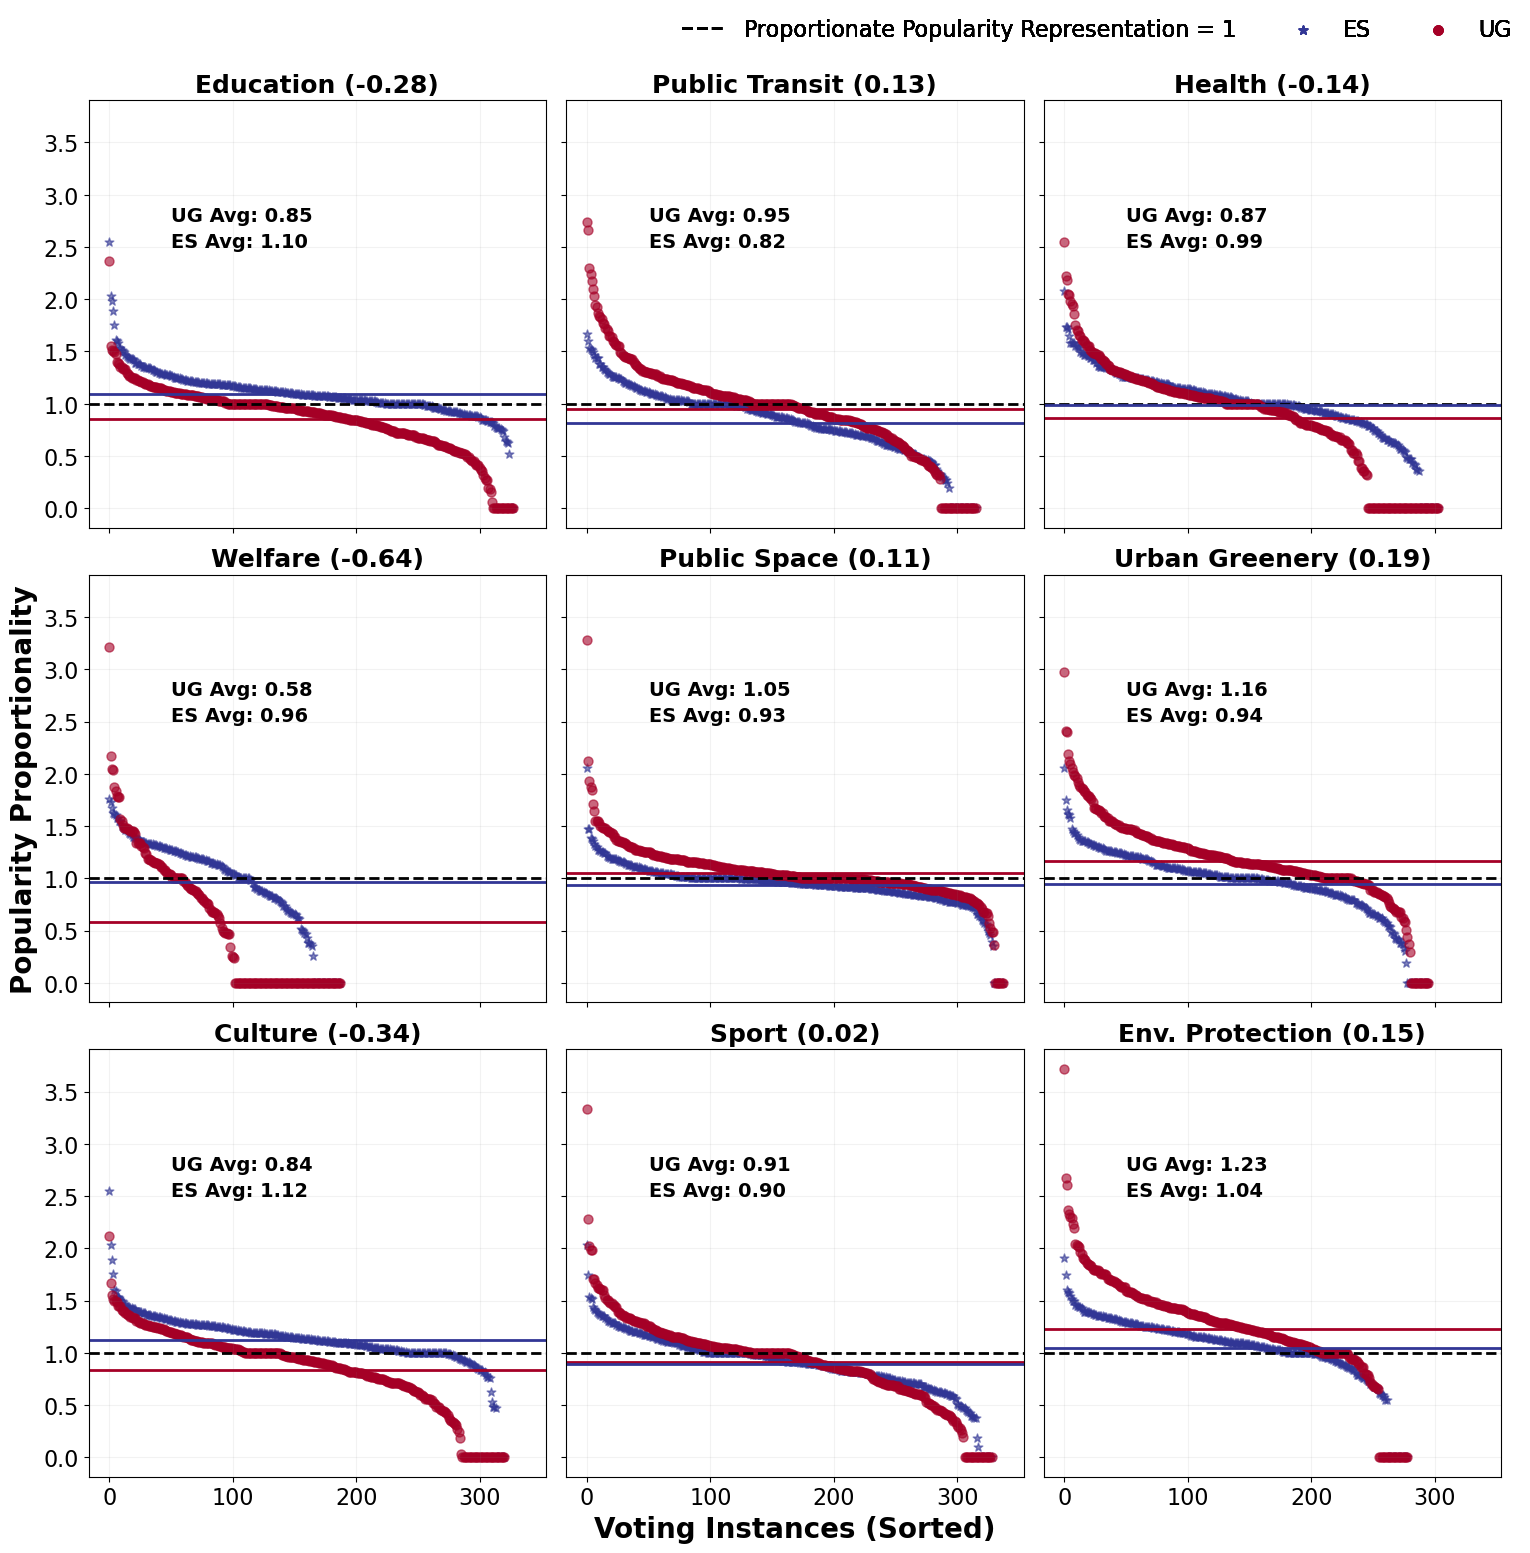

In [24]:
# project proportionality ratio; UG vs ES; project count
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

mes_heatmap_dict = {}
greedy_heatmap_dict = {}
for idx, category in enumerate(categories_set):
    [x_pos, y_pos] = oneD_to_twoD_map[idx]
    temp_df = filtered_valid_pbprojects_df[['election_id', f'{category}_ug_popularity_proportionality', f'{category}_es_popularity_proportionality']]
    temp_df.drop_duplicates(inplace=True)
    
    # threshold line
    axes[x_pos][y_pos].axhline(y=1, color='black', label='Proportionate Popularity Representation = 1', linewidth=2, linestyle='dashed')

    category_ug_pp = temp_df[['election_id', f'{category}_ug_popularity_proportionality', f'{category}_es_popularity_proportionality']].sort_values(by=f'{category}_ug_popularity_proportionality', ascending=False).reset_index()
    category_ug_pp_avg = category_ug_pp[f'{category}_ug_popularity_proportionality'].mean()

    category_es_pp = temp_df[['election_id', f'{category}_ug_popularity_proportionality', f'{category}_es_popularity_proportionality']].sort_values(by=f'{category}_es_popularity_proportionality', ascending=False).reset_index()    
    category_es_pp_avg = category_es_pp[f'{category}_es_popularity_proportionality'].mean()

    axes[x_pos][y_pos].scatter(range(len(category_es_pp)), category_es_pp[f'{category}_es_popularity_proportionality'], label='ES', marker='*', s=42, alpha=0.6, color='#313695')
    axes[x_pos][y_pos].scatter(range(len(category_ug_pp)), category_ug_pp[f'{category}_ug_popularity_proportionality'], label='UG', marker='o', s=42, alpha=0.6, color='#a50026')
    
    
    # average line
    axes[x_pos][y_pos].axhline(y=category_ug_pp_avg, color='#a50026', linestyle='solid', linewidth=2)
    axes[x_pos][y_pos].axhline(y=category_es_pp_avg, color='#313695', linestyle='solid', linewidth=2)

    rdi = (category_ug_pp_avg - category_es_pp_avg) / (category_ug_pp_avg)


    axes[x_pos][y_pos].set_title(f'{category_title_map[category]} ({rdi:.2f})', fontsize=18, fontweight='bold')
    # if x_pos == 0 and y_pos == 2:
    #     axes[x_pos][y_pos].legend(handlelength=1.0, handletextpad=0.5, fontsize=14, frameon=False)

    if x_pos == 1 and y_pos == 0:
        axes[x_pos][y_pos].set_ylabel("Popularity Proportionality", fontsize=20, fontweight='bold')

    if x_pos == 2 and y_pos == 1:
        axes[x_pos][y_pos].set_xlabel('Voting Instances (Sorted)', fontsize=20, fontweight='bold')
    
    axes[x_pos][y_pos].tick_params(axis='both', labelsize=16)
    axes[x_pos][y_pos].grid(axis='both', which='major', color='gray', alpha=0.1)

    # annotate text for avg values
    axes[x_pos][y_pos].text(50, 2.5, f'ES Avg: {category_es_pp_avg:.2f}', fontsize=14, fontweight='bold')
    axes[x_pos][y_pos].text(50, 2.75, f'UG Avg: {category_ug_pp_avg:.2f}', fontsize=14, fontweight='bold')

    # Customize legend
    handles, labels = axes[0][0].get_legend_handles_labels()

    # Create legend outside of the main plot
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.01, 1.04), ncols=4, frameon=False, fontsize=16)
    fig.subplots_adjust(right=1)  # Adjust right side to fit legend

plt.tight_layout()
plt.show()